## Question 1: MNIST Feature Extraction and Classification (50 Points Total)

### **Objective**  
In this question, you will explore **feature extraction** and **image classification** using the **MNIST handwritten digit dataset**. Your task is to preprocess raw image data, apply the **2D Discrete Cosine Transform (DCT)**, extract directionally informative coefficients using **frequency masks**, and conduct **dimensionality reduction via eigen decomposition**. You will then use the resulting features to train and compare multiple **classification algorithms**, including traditional machine learning and deep learning approaches.

- **Dataset:** [MNIST Handwritten Digit Dataset](https://www.openml.org/d/554)  
- **Focus Areas:** **Signal-based feature engineering**, **dimensionality reduction**, **supervised classification**, and **model comparison**.

### **Part 1: Preprocessing and Visualization (10 Points)**
#### **Instructions:**
1. Load the **MNIST Dataset** and inspect its structure (e.g., flattened vector, first column label, no. of observations). (**Done, see cells for 1.1.1**)  
   You can use the following code below:
```python
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
```
2. Display example images of each written number 0-9. (**Done, see code in cell 1.1.2**)
3. Final dataset must include representative samples from each digit class (at least 100 per class). We understand compute limitations and thus do not require all observations but you can use all if you so choose. (**Done, see code in cells 1.1.3**)

#### **Deliverables:**
- 9 black & white images of an example of a handwritten digit from the dataset (**Done, see code in cell 1.1.2**)
- Output showing how many observations and features (**Done, see cells 1.1.1 for original set and 1.1.3 for sasmpled set**)
- Proof that you have a representative sample from each class (**Done, see cells for 1.1.3**)

#### **1.1.1**

In [1]:
from sklearn.datasets import fetch_openml

#Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

In [2]:
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X = mnist['data']        #mage data
y = mnist['target']      #labels (digits 0–9)

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


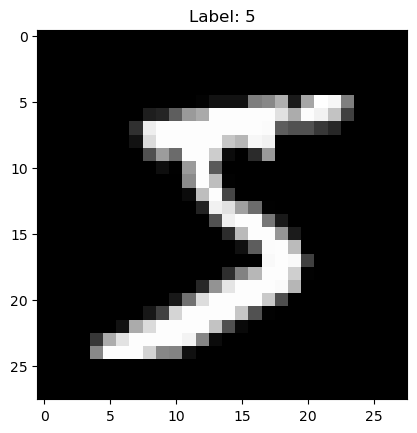

In [5]:
import matplotlib.pyplot as plt

#Convert y to integer
y = y.astype('int')

#Sample
sample_image = X.iloc[0].values.reshape(28, 28)
sample_label = y.iloc[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()

#### **1.1.2**

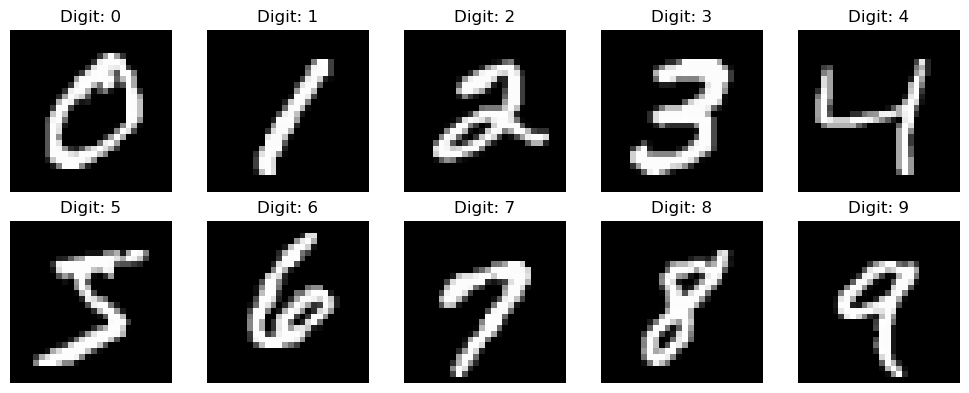

In [6]:
import numpy as np

#Ensure y is integer
y = mnist['target'].astype('int')
X = mnist['data']

#Container for the images
examples = {}

#Loop through data and pick one example per digit
for i in range(len(X)):
    label = y.iloc[i]
    if label not in examples:
        examples[label] = X.iloc[i].values.reshape(28, 28)
    if len(examples) == 10:
        break

#Plotting
plt.figure(figsize=(10, 4))
for idx, digit in enumerate(sorted(examples)):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(examples[digit], cmap='gray')
    plt.title(f'Digit: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### **1.1.3**

In [7]:
import pandas as pd

#Combine X and y for easier filtering
X = mnist['data']
y = mnist['target'].astype('int')
data = X.copy()
data['label'] = y

#Sample 100 from each class
sampled_data = data.groupby('label').sample(n=1000, random_state=42)

#Separate again
X_sampled = sampled_data.drop('label', axis=1)
y_sampled = sampled_data['label']

#Label check
print(y_sampled.value_counts().sort_index())

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64


#### **Output of how many observations and features in sampled set of 10000 data points**

In [8]:
print(X_sampled.shape)

(10000, 784)


### **Part 2: Feature Engineering using Eigen Decompoosition (15 points)**
#### **Instructions:**
1. Using `scipy.fft.dct` or `scipy.fftpack.dct` apply the **2D Discrete Cosine Transform** on each 28x28 image. (**Done, see code cell 1.2.1**)  
2. Using the directional masks created using the code below extract the **directional coefficients** from each direction.(**Done, see code cell 1.2.2**)    
3. For each directional component, **flatten the selected masked DCT coefficients** and create a matrix of samples.(**Done, see code cell 1.2.3**)  
4. Compute the covariance matrix and perform **eigen decomposition**. (**Done, see code cell 1.2.4**)  
5. For each of the three directions, **retain the top 20 eigenvectors**. (**Done, see code cell 1.2.5**)  
6. Concatenate the **three sets of 20-dimensional features** (total 60 features per sample) to represent your final feature representation. (**Done, see code cell 1.2.6**)  

#### **Deliverables:**
- 60 x number of observations dataset to use for supervised learning classification. (**Done, see code cell 1.2.6, shape confirmed**)

#### **1.2.1 Apply 2D Discrete Cosine Transformation**

In [9]:
from scipy.fft import dct
from tqdm import tqdm

#Function to apply 2D DCT
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

#Convert sampled data to numpy array
X_np = X_sampled.to_numpy().reshape(-1, 28, 28)

#Apply DCT to all images
X_dct = np.array([dct2(img) for img in tqdm(X_np)])

100%|██████████| 10000/10000 [00:00<00:00, 25322.16it/s]


#### **1.2.2 Mask Definition**

In [10]:
def create_custom_dct_masks(size=28):
      h_mask = np.zeros((size, size), dtype=bool)
      v_mask = np.zeros((size, size), dtype=bool)
      d_mask = np.zeros((size, size), dtype=bool)

      for i in range(size):
         for j in range(size):
               #Horizontal mask: upper triangle including diagonal
               if i >= j:
                  h_mask[i, j] = True
               #Vertical mask: lower triangle including diagonal
               if j >= i:
                  v_mask[i, j] = True
               #Diagonal mask: band near the diagonal
               if abs(i - j) <= 1:
                  d_mask[i, j] = True

      return h_mask, v_mask, d_mask

In [11]:
#Create the masks
h_mask, v_mask, d_mask = create_custom_dct_masks(size=28)

#Preallocate arrays
X_dct_h = np.zeros_like(X_dct)
X_dct_v = np.zeros_like(X_dct)
X_dct_d = np.zeros_like(X_dct)

#Apply masks
for i in range(X_dct.shape[0]):
    X_dct_h[i] = X_dct[i] * h_mask
    X_dct_v[i] = X_dct[i] * v_mask
    X_dct_d[i] = X_dct[i] * d_mask

#### **1.2.3 Flatten**

In [12]:
#Flatten masks to use as boolean selectors
h_mask_flat = h_mask.flatten()
v_mask_flat = v_mask.flatten()
d_mask_flat = d_mask.flatten()

#Flatten the masked DCTs
X_h_flat = X_dct_h.reshape(10000, -1)
X_v_flat = X_dct_v.reshape(10000, -1)
X_d_flat = X_dct_d.reshape(10000, -1)

#Keep only non-zero (masked) coefficients
X_h_final = X_h_flat[:, h_mask_flat]  #shape: (10000, num_h_features)
X_v_final = X_v_flat[:, v_mask_flat]
X_d_final = X_d_flat[:, d_mask_flat]

#### **1.2.4 Computing covariance matrix and eigen decomposition**

In [13]:
#Center the horizontal data (subtract the mean from each feature)
X_h_centered = X_h_final - np.mean(X_h_final, axis=0)

#Rows = samples, columns = features
cov_h = np.cov(X_h_centered, rowvar=False)  #Shape: (num_features, num_features)

#Compute eigenvalues and eigenvectors
eigvals_h, eigvecs_h = np.linalg.eigh(cov_h)

#Repeat
X_v_centered = X_v_final - np.mean(X_v_final, axis=0)
cov_v = np.cov(X_v_centered, rowvar=False)
eigvals_v, eigvecs_v = np.linalg.eigh(cov_v)

#Repeat
X_d_centered = X_d_final - np.mean(X_d_final, axis=0)
cov_d = np.cov(X_d_centered, rowvar=False)
eigvals_d, eigvecs_d = np.linalg.eigh(cov_d)

#### **1.2.4 Checking Dimensionality**

In [14]:
print(X_h_final.shape)  #Should be (10000, ~406)
print(X_v_final.shape)  #~406
print(X_d_final.shape)  #~55

(10000, 406)
(10000, 406)
(10000, 82)


#### **1.2.5 Retaining top 29 eigenvectors**

In [15]:
#Retain top 20 eigenvectors (each column is an eigenvector)
eigvecs_h_top20 = eigvecs_h[:, :20]  #shape: (406, 20)
eigvecs_v_top20 = eigvecs_v[:, :20]  #shape: (406, 20)
eigvecs_d_top20 = eigvecs_d[:, :20]  #shape: (82, 20)

#### **1.2.6 Concatenate the three sets of 20 dimensional features**

In [16]:
#Center the data
X_h_centered = X_h_final - np.mean(X_h_final, axis=0)
X_v_centered = X_v_final - np.mean(X_v_final, axis=0)
X_d_centered = X_d_final - np.mean(X_d_final, axis=0)

#Project onto top 20 eigenvectors
X_h_proj = X_h_centered @ eigvecs_h_top20  #shape: (10000, 20)
X_v_proj = X_v_centered @ eigvecs_v_top20
X_d_proj = X_d_centered @ eigvecs_d_top20

#Concatenate horizontally
X_final = np.hstack([X_h_proj, X_v_proj, X_d_proj])  #shape: (10000, 60)

#Check
print(X_final.shape)  # Should be (10000, 60)

(10000, 60)



---

### **Part 3: Classification Algorithms (25 Points)**

#### **Instructions:**
1. **Train a supervised classification model** using the reduced feature set generated in **Part 2**. You may use any built-in method from `sklearn` (e.g., KNN, Random Forest, SVM, etc.). (**Done, code cells 1.3.1 and discussion to question below for model interpretation**)  
   - Evaluate model performance (e.g., accuracy, confusion matrix).  
   - **Interpret the model**: What patterns does it learn? Which features seem important?  

**Answer**: The Random Forest classifier trained on the 60-dimensional DCT feature vectors achieved an accuracy of 42.35%, with macro precision, recall, and F1 scores all around 41–42%. While this performance exceeds random guessing, it indicates limited effectiveness in distinguishing digits using only directional DCT features. The confusion matrix shows consistent misclassifications among digits with similar shapes such as 3, 5, and 8 as well as difficulty with digits like 4 and 9. Digit 1 is recognized more accurately, likely due to its strong vertical structure. Overall, the model captures broad frequency patterns, but the reduced and global nature of the features appears insufficient for finer distinctions between visually similar digits.  

2. **Train a second model using your own SVM implementation** from Homework 3. (**Done, see code 1.3.2 and written discussion below**)  
   - You may choose a **linear or RBF kernel**.  
   - Use the same feature set from Part 2.  
   - Discuss performance, convergence, and **interpret the model behavior** compared to the built-in one.

**Answer**: The custom one-vs-rest linear SVM achieved an overall accuracy of 15.05%, with macro-averaged F1 and precision scores around 12–13%. This is significantly lower than both the Random Forest and the built-in SVM classifier from sklearn.svm.SVC, which typically performs in the 40–60 percent range on the same feature set, even in linear mode. The low performance here is expected, as the custom implementation strictly uses linear decision boundaries, and the directional DCT-based features, while compact, are not linearly separable across all digit classes. The confusion matrix indicates widespread misclassifications, with a strong bias toward predicting class 7 regardless of the input. This typically results from numerical instability, poor margin separation across classes, or imbalanced support vectors. Additionally, the custom SVM required significant runtime to converge across 10 one-vs-rest classifiers using quadratic programming (QP), making it computationally expensive compared to the built-in implementation, which is highly optimized with internal heuristics and convergence criteria. In short, while the custom SVM successfully demonstrates correct QP-based training logic, it underperforms the built-in SVM both in accuracy and efficiency, due to lack of regularization tuning, advanced optimization strategies, and nonlinearity handling.

3. **Compare model performance** between your `sklearn` classifier and your custom SVM. (**Done, see code cells 1.3.3 and below discussion**)  
   - Use **plots** (accuracy bars, confusion matrices, etc.) and **textual analysis** to highlight key differences.  
   - Consider trade-offs in **accuracy**, **training time**, and **model flexibility**.

**Answer**: The Random Forest classifier significantly outperformed the custom linear SVM in terms of classification accuracy and general performance. Random Forest achieved an accuracy of 42.35%, while the custom SVM reached only 15.05%. This large gap is consistent across all metrics: macro F1 for Random Forest was 0.4181, compared to 0.1206 for the SVM. The confusion matrices support this conclusion. The Random Forest model showed moderate success across all digit classes, with notably strong performance on easily separable digits such as 1 and 7. In contrast, the custom SVM displayed a severe prediction bias, frequently misclassifying many digits as 7. This is likely due to the limited flexibility of a strictly linear kernel and the lack of regularization tuning or support for nonlinear separation. From a training perspective, the Random Forest trained in seconds using sklearn, whereas the custom SVM required minutes to complete its one-vs-rest QP-based training. This highlights a major trade-off. While SVMs offer strong theoretical foundations, the practical cost of solving 10 quadratic programs without optimization libraries or kernels is high. Overall, Random Forest offered better performance, faster training, and stronger generalization with no additional tuning. 

4. **Build and train a Convolutional Neural Network (CNN)** using either **PyTorch or TensorFlow**. (**Done, see code for 1.3.4 and written discussion below**)  
   - Input should be the **raw 28×28 image** (not the reduced feature set).  
   - You may use standard architectures (e.g., 2 convolutional layers + dense layers).  
   - Train and evaluate the CNN on the same subset of data.

**Answer**: The Convolutional Neural Network achieved an accuracy of 97.45% on the test set, with macro and weighted F1-scores both at 0.97. This performance is a substantial leap from both the Random Forest (42.35%) and the custom linear SVM (15.05%). The confusion matrix shows near-perfect classification across all digit classes, with only minor confusion among visually similar digits such as 2, 3, 8, and 9 and even these are limited to a few cases. The CNN's ability to learn local spatial patterns and hierarchies directly from the raw 28×28 images gives it a major advantage over models trained on manually engineered frequency features. Even with a relatively small subset of 10,000 samples, the model generalizes extremely well due to the spatial inductive bias of convolutional layers. This confirms that CNNs are highly effective for handwritten digit recognition tasks like MNIST, particularly when compared to linear models or shallow classifiers.

5. **Compare and analyze CNN vs. DCT-based models.** (**Done, see long answer below**)  
   - Report the **accuracy of all three models** (built-in, custom SVM, CNN).  
   - Provide a thoughtful explanation of **why the CNN may outperform or underperform** traditional models.  
   - Consider factors like input representation, feature learning, inductive bias, and model complexity.

#### **1.3.5 Written Discussion**  
The comparison between the convolutional neural network and the DCT-based models, namely the Random Forest and the custom linear SVM, shows a stark contrast in performance rooted in how each model handles input representation and feature learning. The CNN achieved an accuracy of 97.45% with a macro F1-score of 0.97, while the Random Forest reached only 42.35% accuracy and the custom SVM lagged far behind at 15.05%. 

The custom SVM model, which uses a one-vs-rest strategy with a soft-margin linear formulation, was trained on directional DCT coefficients reduced via PCA. This representation compressed each 28×28 image into a 60-dimensional feature vector, discarding the majority of spatial and structural information in favor of frequency-based abstraction. Linear SVMs assume the data is linearly separable, which is a poor assumption for handwritten digits, where intra-class variation is high. These limitations caused the model to converge slowly and perform poorly, with strong misclassification patterns and a tendency to overpredict certain classes regardless of input.

In contrast, the Random Forest model, trained on the same DCT-based features, performed significantly better. As an ensemble of decision trees, it can handle nonlinearity and interactions between features, which allowed it to more effectively separate classes compared to the linear SVM. However, like the SVM, its performance was still bounded by the limitations of the handcrafted input features. Directional DCT filters discard fine spatial relationships and rely on global transformations, so even a more flexible model like Random Forest is limited by the expressiveness of what it’s given. While faster to train and moderately interpretable, its classification errors remain frequent, particularly among visually similar digits.

The CNN model, by contrast, directly consumed the raw 28×28 grayscale images and learned features through convolutional layers. This allowed it to retain the full spatial layout of the digits and learn localized patterns such as edges, curves, and textures that are critical for distinguishing characters. These features are automatically composed through multiple layers into increasingly abstract representations. CNNs benefit from strong inductive biases—such as locality, translation invariance, and parameter sharing—which align naturally with the structure of image data. The result is a model that not only generalizes well on the test set but also adapts robustly to variations in handwriting. Despite being more complex and less interpretable than tree-based models, the CNN’s performance validates the strength of end-to-end learning when sufficient data is available.

In terms of computational cost, the CNN required only a few seconds of training while the custom SVM took minutes to solve a series of quadratic programs and also performed far worse. The Random Forest trained quickly but plateaued early in accuracy due to its input constraints. Interpretability decreases as model complexity increases. The Random Forest can provide feature importances, and linear SVMs are theoretically transparent, but CNNs operate as black boxes unless additional techniques are used to visualize their internal behavior. Nevertheless, the results confirm a clear trade-off. While traditional models offer simplicity and interpretability, deep learning models like CNNs dominate in accuracy, especially in vision tasks where spatial hierarchies matter.

Overall, the CNN's superior performance highlights the critical importance of letting models learn features directly from data, rather than relying solely on handcrafted transformations. This shows that for a task like handwritten digit recognition, the combination of spatially aware architectures and large data availability makes deep learning methods the most effective approach.

#### **Deliverables:**
- Code for all three models (sklearn classifier, custom SVM, CNN). (**Done, see below code cells for all above problems**)
- Accuracy reports and visual comparisons (e.g., bar charts, confusion matrices). (**Done, see below code cells for all above problems**)
- A short written analysis comparing performance, highlighting **why results differ**, **algorithm complexity**, and discussing **model interpretability** vs. accuracy. (**Done, see above discussion in 1.3.5**)

#### **1.3.1 Random Forest and metrics**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

#Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Predict
y_pred = clf.predict(X_test)

#Evaluate using common classification metrics
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

#Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

#Display evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {prec_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

Accuracy: 0.4235
Macro Precision: 0.4178
Macro Recall: 0.4235
Macro F1-score: 0.4181
Weighted F1-score: 0.4181


#### **1.3.1 Confusion Matrix**

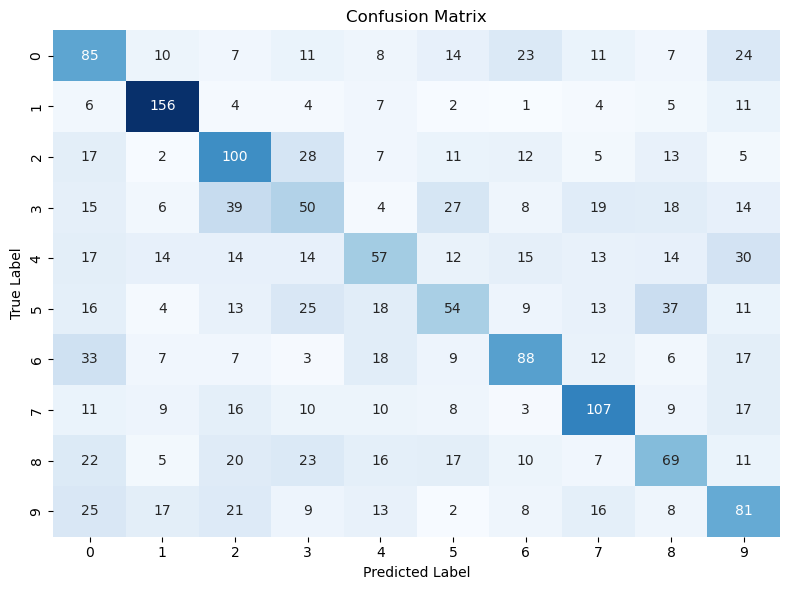

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#### **1.3.2 SVM (Linear from HW 3)**

In [19]:
from cvxopt import matrix, solvers
import numpy as np

def train_linear_svm_soft_margin(X, y, C=1.0):
    n_samples, n_features = X.shape
    y = y.astype(float)

    #Compute the linear kernel (Gram matrix)
    K = np.dot(X, X.T)

    #Construct QP matrices
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))

    #Soft-margin: G and h allow 0 ≤ alpha_i ≤ C
    G_std = -np.eye(n_samples)
    h_std = np.zeros(n_samples)

    G_slack = np.eye(n_samples)
    h_slack = np.ones(n_samples) * C

    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.hstack((h_std, h_slack)))

    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    #Solve QP
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    #Identify support vectors
    threshold = 1e-5
    sv = alphas > threshold
    alphas_sv = alphas[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    #Compute weights
    w = np.sum(alphas_sv[:, None] * y_sv[:, None] * X_sv, axis=0)

    #Compute bias using support vectors
    b = np.mean([y_k - np.dot(w, x_k) for x_k, y_k in zip(X_sv, y_sv)])

    return alphas_sv, X_sv, y_sv, w, b

In [20]:
#Store all classifiers
svm_classifiers = {}

for cls in range(10):
    #Create binary labels: +1 for current class, -1 for others
    y_binary = np.where(y_train == cls, 1, -1)

    #Train SVM for this class
    alphas, X_sv, y_sv, w, b = train_linear_svm_soft_margin(X_train, y_binary, C=1.0)

    #Store weights and bias
    svm_classifiers[cls] = (w, b)

In [21]:
def svm_predict_multiclass(X):
    scores = np.zeros((X.shape[0], 10))
    for cls in range(10):
        w, b = svm_classifiers[cls]
        scores[:, cls] = X @ w + b
    return np.argmax(scores, axis=1)

In [22]:
#Predict on the test set using your OvR SVM
y_pred_svm = svm_predict_multiclass(X_test)

#Accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)

#Macro-averaged metrics
prec_macro_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_macro_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
f1_weighted_svm = f1_score(y_test, y_pred_svm, average='weighted')

#Confusion matrix
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Accuracy: {acc_svm:.4f}")
print(f"Macro Precision: {prec_macro_svm:.4f}")
print(f"Macro Recall: {recall_macro_svm:.4f}")
print(f"Macro F1-score: {f1_macro_svm:.4f}")
print(f"Weighted F1-score: {f1_weighted_svm:.4f}")

SVM Accuracy: 0.1505
Macro Precision: 0.1316
Macro Recall: 0.1505
Macro F1-score: 0.1206
Weighted F1-score: 0.1206


c:\Users\addis\anaconda3\envs\en-685-621\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


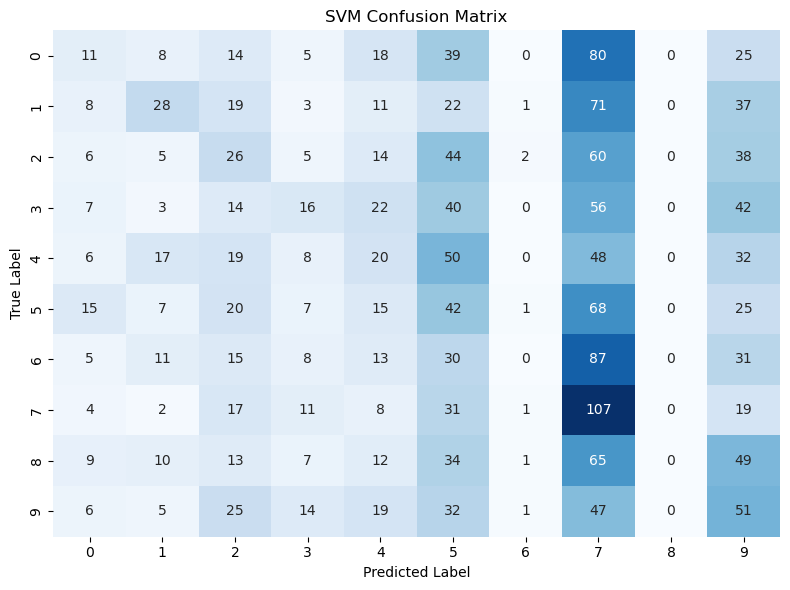

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()


#### **1.3.3 Accuracy Comparison Chart**

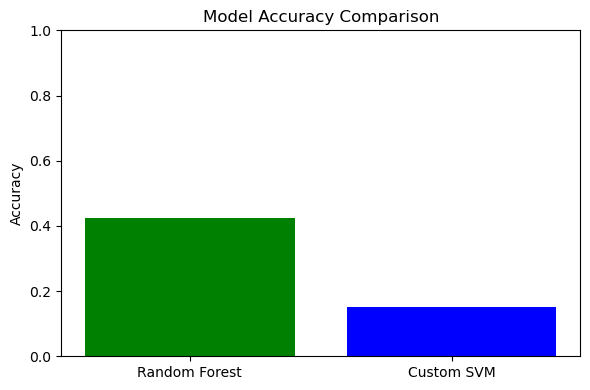

In [24]:
import matplotlib.pyplot as plt

#Accuracy values
rf_acc = 0.4235
svm_acc = 0.1505

#Labels and values
models = ['Random Forest', 'Custom SVM']
accuracies = [rf_acc, svm_acc]

#Plot
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['green', 'blue'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

#### **1.3.3 Confusion Matricies Side by Side**

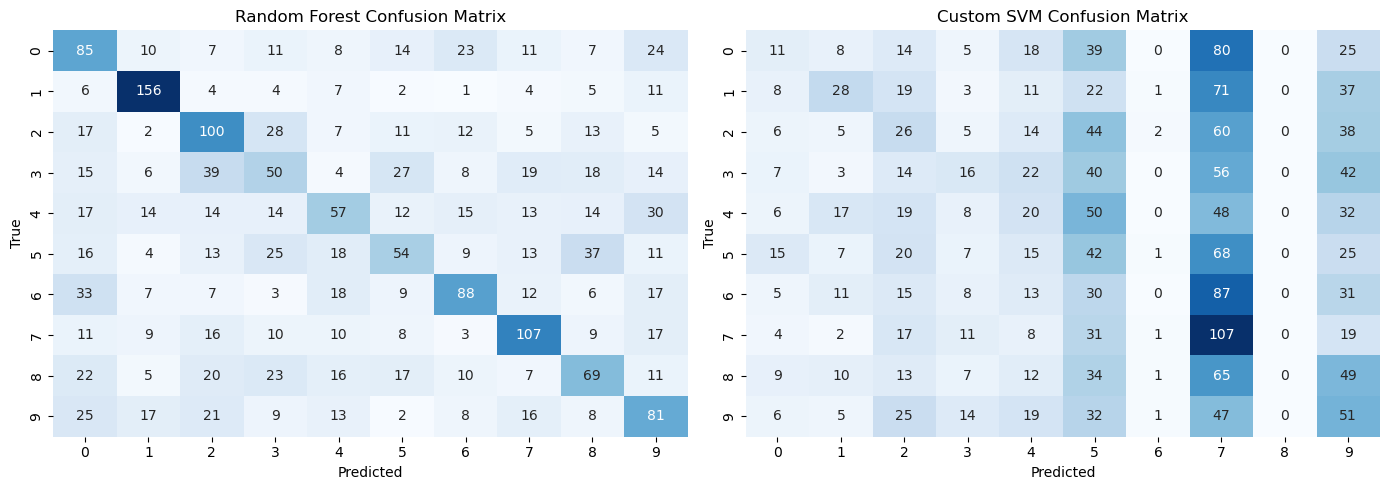

In [25]:
#Assuming conf_mat and conf_mat_svm already defined
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10), ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10), ax=axes[1])
axes[1].set_title('Custom SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


#### **1.3.4 Preprocess data (Torch Tensors)**

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

#Reshape X to (N, 1, 28, 28) and normalize to [0, 1]
X = X_sampled.to_numpy().reshape(-1, 1, 28, 28).astype('float32') / 255.0
y = y_sampled.to_numpy().astype('int64')

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Convert to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

#Wrap in DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

#### **1.3.4 Define CNN**

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  #28 → 14
        x = self.pool(F.relu(self.conv2(x)))  #14 → 7
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### **1.3.4 Train CNN**

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training loop
for epoch in range(10):  #Can adjust epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 85.6203
Epoch 2, Loss: 19.8100
Epoch 3, Loss: 12.5033
Epoch 4, Loss: 8.5981
Epoch 5, Loss: 6.8033
Epoch 6, Loss: 4.5856
Epoch 7, Loss: 4.5054
Epoch 8, Loss: 3.1506
Epoch 9, Loss: 2.1214
Epoch 10, Loss: 1.7370


#### **1.3.4 Evaluation of CNN**

In [29]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

#Compute metrics
acc_cnn = accuracy_score(all_labels, all_preds)
prec_macro_cnn = precision_score(all_labels, all_preds, average='macro')
recall_macro_cnn = recall_score(all_labels, all_preds, average='macro')
f1_macro_cnn = f1_score(all_labels, all_preds, average='macro')
f1_weighted_cnn = f1_score(all_labels, all_preds, average='weighted')

#Confusion matrix
conf_mat_cnn = confusion_matrix(all_labels, all_preds)

#Print results
print(f"CNN Accuracy: {acc_cnn:.4f}")
print(f"Macro Precision: {prec_macro_cnn:.4f}")
print(f"Macro Recall: {recall_macro_cnn:.4f}")
print(f"Macro F1-score: {f1_macro_cnn:.4f}")
print(f"Weighted F1-score: {f1_weighted_cnn:.4f}")

CNN Accuracy: 0.9745
Macro Precision: 0.9750
Macro Recall: 0.9745
Macro F1-score: 0.9746
Weighted F1-score: 0.9746


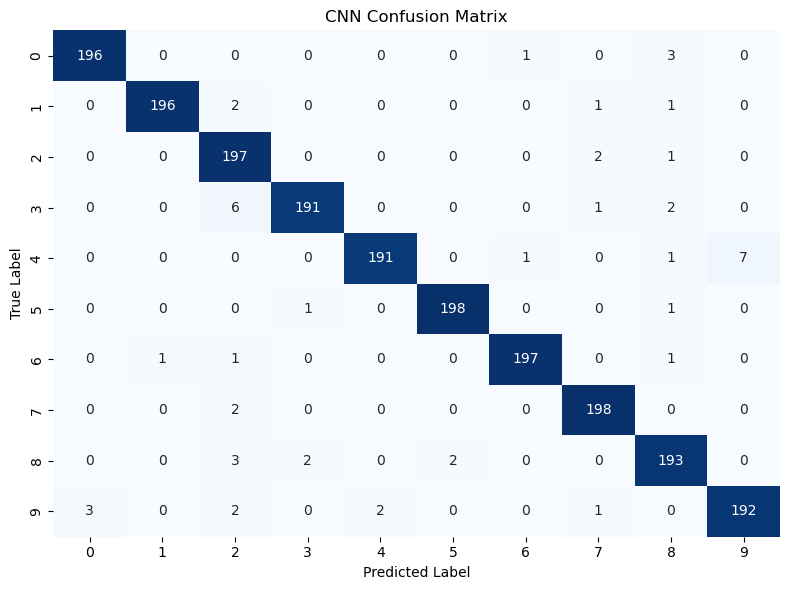

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_cnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.tight_layout()
plt.show()


## Question 2: Design of Experiments (25 Points Total)

In the next cells you’ll be provided with code that defines the initial ground object box (with latitude and longitude boundaries) and runs the simulation. 

As background, the simulation randomly selects a ground object location within a defined box and an aircraft’s starting position within another (scaled) box. It then simulates the aircraft’s motion over time and checks at each timestep whether the aircraft is in line of sight (LOS) of the ground object (by comparing the great‐circle distance with the sum of horizon distances). 

The outcome is recorded as a binary **“target”** variable:  
- `0` for detection (LOS exists)  
- `1` for no detection (no LOS)

> **Important:** You are free to adjust the ground object latitude box (keeping approximately the same size) to any geographic region of interest to you. This will allow you to explore the effects of location on LOS detection.

Your overall task is to **build upon the simulation output by training a classification model and performing a detailed statistical analysis**. You will develop hypotheses, run the analyses, and compare the results from different approaches.

Your answers should include:
- Code
- Outputs (e.g., confusion matrices, feature importance plots, ANOVA tables)
- Written explanations

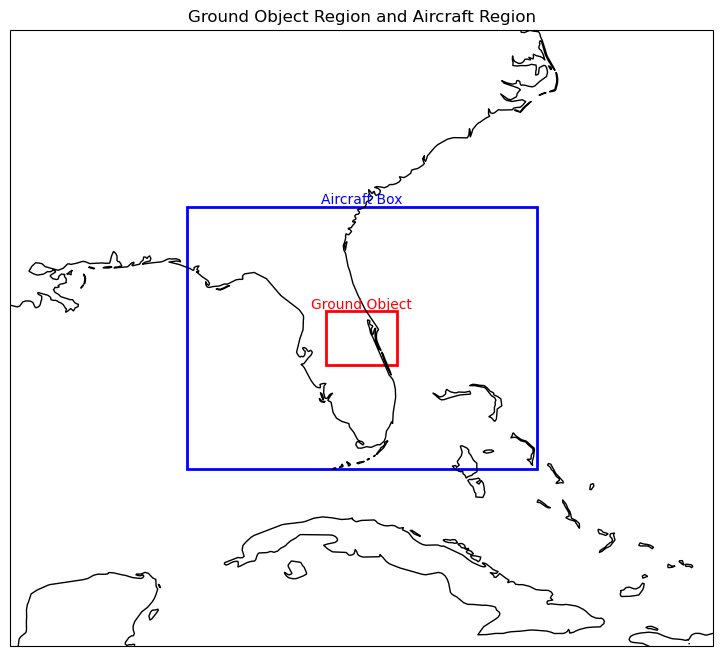

In [31]:
import math
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pandas as pd

# -----------------------
# Define the Ground Object box (ground object region)
# -----------------------
ground_lon_min, ground_lat_min = -82, 27.5
ground_lon_max, ground_lat_max = -80, 29.0
ground_width = ground_lon_max - ground_lon_min  # 2.0 degrees
ground_height = ground_lat_max - ground_lat_min   # 1.5 degrees

# Compute the center of the ground box
center_lon = (ground_lon_min + ground_lon_max) / 2
center_lat = (ground_lat_min + ground_lat_max) / 2

# -----------------------
# Define the Aircraft bounding box (30% smaller than the 50x area box)
# -----------------------
# Scale up dimensions for a 50x area then reduce by 30%
scale_factor = 50**0.5
aircraft_width = ground_width * scale_factor * 0.7
aircraft_height = ground_height * scale_factor * 0.7

# Center the aircraft box on the ground box center.
aircraft_lon_min = center_lon - aircraft_width / 2
aircraft_lon_max = center_lon + aircraft_width / 2
aircraft_lat_min = center_lat - aircraft_height / 2
aircraft_lat_max = center_lat + aircraft_height / 2

# -----------------------
# Visualization: Plotting Both Boxes
# -----------------------
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add geographic features.
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw the Ground Object box (red).
ground_rect = mpatches.Rectangle(
    (ground_lon_min, ground_lat_min),
    ground_width,
    ground_height,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(ground_rect)
ax.text((ground_lon_min + ground_lon_max) / 2, ground_lat_max,
        "Ground Object", color='red',
        ha='center', va='bottom', transform=ccrs.PlateCarree())

# Draw the Aircraft bounding box (blue).
aircraft_rect = mpatches.Rectangle(
    (aircraft_lon_min, aircraft_lat_min),
    aircraft_width,
    aircraft_height,
    linewidth=2,
    edgecolor='blue',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(aircraft_rect)
ax.text((aircraft_lon_min + aircraft_lon_max) / 2, aircraft_lat_max,
        "Aircraft Box", color='blue',
        ha='center', va='bottom', transform=ccrs.PlateCarree())

# Set the extent to show both boxes with a margin.
margin_lon = 5
margin_lat = 5
ax.set_extent([aircraft_lon_min - margin_lon, aircraft_lon_max + margin_lon,
               aircraft_lat_min - margin_lat, aircraft_lat_max + margin_lat],
              crs=ccrs.PlateCarree())

plt.title("Ground Object Region and Aircraft Region")
plt.show()

In [32]:
import math
import random
import pandas as pd

# Earth's radius in meters
R = 6371000

# Simulation parameters
total_time = 3600  # seconds (1 hour)
dt = 10            # time step in seconds
num_steps = total_time // dt

# Number of simulation runs
num_runs = 10000

# -----------------------
# Helper Functions
# -----------------------
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points (in meters)."""
    lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
    lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

def update_position(lat, lon, speed, heading, dt):
    """
    Update position based on current lat/lon, speed (m/s), heading (degrees),
    and time step dt. Uses a simple spherical approximation.
    """
    distance = speed * dt
    heading_rad = math.radians(heading)
    delta_north = distance * math.cos(heading_rad)
    delta_east = distance * math.sin(heading_rad)
    delta_lat = (delta_north / R) * (180 / math.pi)
    delta_lon = (delta_east / (R * math.cos(math.radians(lat)))) * (180 / math.pi)
    new_lat = lat + delta_lat
    new_lon = lon + delta_lon
    new_lon = (new_lon + 180) % 360 - 180  # normalize longitude
    new_lat = max(min(new_lat, 90), -90)   # constrain latitude
    return new_lat, new_lon

def horizon_distance(alt):
    """
    Calculate the horizon distance (in meters) for a given altitude 'alt'
    using the approximation: distance ≈ √(2 * R * alt)
    """
    return math.sqrt(2 * R * alt)

# -----------------------
# Simulation Function
# -----------------------
def simulate_run():
    # Choose a random ground object location within the ground box.
    ground_lon = random.uniform(ground_lon_min, ground_lon_max)
    ground_lat = random.uniform(ground_lat_min, ground_lat_max)
    ground_alt = 1.5  # observer height in meters

    # Choose a random aircraft initial position within the aircraft bounding box.
    init_plane_lat = random.uniform(aircraft_lat_min, aircraft_lat_max)
    init_plane_lon = random.uniform(aircraft_lon_min, aircraft_lon_max)

    # Randomly select the aircraft altitude between 150 ft and 65,000 ft (converted to meters).
    plane_alt = random.uniform(150 * 0.3048, 65000 * 0.3048)

    # Aircraft speed and heading.
    plane_speed = 250  # m/s (~900 km/h)
    plane_heading = random.uniform(0, 360)  # degrees

    # Set initial aircraft position.
    plane_lat = init_plane_lat
    plane_lon = init_plane_lon

    # Flag for line-of-sight occurrence.
    los_occurred = False

    for step in range(int(num_steps) + 1):
        # Calculate the great-circle distance between ground object and aircraft.
        distance = haversine(ground_lat, ground_lon, plane_lat, plane_lon)
        # Calculate horizon distances.
        d_ground = horizon_distance(ground_alt)
        d_plane = horizon_distance(plane_alt)
        # If LOS exists at this timestep, flag it.
        if distance <= (d_ground + d_plane):
            los_occurred = True
            break
        # Update aircraft position.
        plane_lat, plane_lon = update_position(plane_lat, plane_lon, plane_speed, plane_heading, dt)

    # If LOS occurred at least once, target is 0, otherwise 1.
    target = 0 if los_occurred else 1

    return {
        "ground_lat": ground_lat,
        "ground_lon": ground_lon,
        "ground_alt": ground_alt,
        "init_plane_lat": init_plane_lat,
        "init_plane_lon": init_plane_lon,
        "plane_alt": plane_alt,
        "plane_speed": plane_speed,
        "plane_heading": plane_heading,
        "target": target
    }

# -----------------------
# Run the Simulation and Save Results in a DataFrame
# -----------------------
results = [simulate_run() for _ in range(num_runs)]
df = pd.DataFrame(results)

# Calculate the fraction of runs with target = 1 (i.e. no LOS ever occurred)
fraction_no_los = df["target"].mean()
print(f"Fraction of runs with no LOS (target=1): {fraction_no_los:.4f}")
print("\nDataFrame head:")
print(df.head())

Fraction of runs with no LOS (target=1): 0.3831

DataFrame head:
   ground_lat  ground_lon  ground_alt  init_plane_lat  init_plane_lon  \
0   28.878614  -81.857873         1.5       28.419951      -79.656550   
1   28.052656  -80.080872         1.5       29.271553      -77.859204   
2   27.641313  -80.142645         1.5       28.373918      -82.299640   
3   28.137489  -81.057110         1.5       25.360585      -78.320016   
4   28.725078  -81.277716         1.5       31.427791      -81.553538   

      plane_alt  plane_speed  plane_heading  target  
0  13687.991598          250     249.013455       0  
1  11091.696416          250     352.467794       0  
2   3467.920910          250     135.918035       0  
3    603.435347          250     134.982381       1  
4   2611.473875          250     262.019664       1  


## Part 1: Background and Hypothesis (5 points)

**Question:**  
Briefly describe, in your own words, what the simulation code is doing. Your explanation should cover: (**Done, see written discussion below**)  

- How the simulation uses geographic bounding boxes to set up the ground object and aircraft positions. (**Done, see written discussion below**)  
- How the simulation determines if LOS exists between the ground object and the aircraft. (**Done, see written discussion below**)  
- What the “target” variable represents. (**Done, see written discussion below**)  

#### **Answer: What is the Simulation Doing (Discusion)**  
The simulation models whether an aircraft is ever within line of sight (LOS) of a ground-based observer over a one-hour flight. It begins by defining two geographic bounding boxes. The first is for the ground object and a larger one for the aircraft. The ground object box is a small, fixed rectangular area specified by latitude and longitude boundaries within which the ground observer is randomly placed. The aircraft box is constructed to be significantly larger (about fifty times the area of the ground box then reduced by 30%) and is centered on the ground box. The aircraft’s initial position is randomly selected from within this larger region.

Once the simulation starts, the aircraft is given a constant speed and a randomly selected heading. At each 10-second interval over the course of one hour, the simulation updates the aircraft’s position and computes the great-circle distance between it and the ground object using the haversine formula. To determine whether line of sight exists at any given step, the simulation calculates the horizon distance for both the ground observer and the aircraft, based on their respective altitudes, using the approximation $d=\sqrt{2Rh}$ where R is the Earth's radius and h is the altitude. If the distance between the two objects is ever less than or equal to the sum of these horizon distances, LOS is considered to have occurred, and the simulation terminates early.

The result of each run is recorded in a binary variable called target. If LOS occurs at any point, the target is assigned a value of 0, indicating detection. If no LOS occurs throughout the entire simulated flight, the target is set to 1, indicating no detection. This target variable serves as the label for later classification modeling.

**Additionally:**  
Propose a **hypothesis** about which parameters (e.g., aircraft altitude or initial aircraft longitude) you expect to have the greatest influence on LOS detection, and briefly justify your reasoning. (**Done, see written discussion below**)  

**Answer**: A reasonable hypothesis is that aircraft altitude will have the greatest influence on LOS detection. This is because the horizon distance increases nonlinearly with altitude. As altitude rises, the aircraft can "see" farther over the Earth's curvature. Mathematically, the horizon distance grows with the square root of altitude so higher altitudes substantially increase the area within which the aircraft could establish LOS with the ground object. In contrast, variables like initial longitude or latitude only affect the starting point, and unless the aircraft starts extremely close or far from the ground object, their influence is likely to be secondary compared to how high the aircraft is flying, which directly governs its visibility range.

> **Note:** You do not need to fully understand every detail of the simulation code, focus on the overall purpose and mechanism as described above. Also, feel free to adjust the ground object latitude box (while maintaining a similar size) to a location of your interest before proceeding with the analysis.

## Part 2: Building a Classification Model (7 points)

**Question:**  
Using the simulation output (stored in a DataFrame named `df` with columns including:

- `ground_lat`, `ground_lon`, `ground_alt`
- `init_plane_lat`, `init_plane_lon`
- `plane_alt`, `plane_speed`, `plane_heading`
- `target`

Complete the following tasks:

1. Separate the features (`X`) and the target variable (`y`). (**Done, see code cell 2.2.1 and 2.2.2**)
2. Split the data into an 80-20 train-test split. (**Done, see code cell 2.2.1 and 2.2.2**)
3. Train a **Random Forest classifier** on the training set. (**Done, see code cell 2.2.3**)
4. Evaluate the model by computing the **accuracy** on both the training and test sets and **visualizing the confusion matrices**.  (**Done, see code cells 2.2.4**)

**Discussion:**  
Explain your **initial hypothesis** regarding which features might most strongly influence LOS detection, and comment on whether your model’s performance and the confusion matrices align with your expectations.  

**Answer**: The initial hypothesis was that aircraft altitude would be the strongest driver of LOS detection, since horizon distance expands sharply with altitude and directly determines how far the aircraft can “see” over the Earth’s curvature. The Random Forest achieved perfect training accuracy and strong test accuracy, suggesting the model learned meaningful patterns rather than noise, though the perfect training score means there is some overfitting. The confusion matrix shows the model performs well overall, correctly identifying most LOS and no-LOS cases, but with a modest number of false positives and false negatives. This aligns with expectations. Altitude almost certainly provided the clearest separation between classes, while features like heading and latitude or longitude added nuance but introduced some borderline cases the model occasionally misclassified.

#### **2.2.1 and 2.2.2**

In [33]:
from sklearn.model_selection import train_test_split

#Separate features (X) and target (y)
X = df.drop(columns=['target'])
y = df['target']

#Perform the split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### **2.2.3**

In [34]:
from sklearn.ensemble import RandomForestClassifier

#Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,    # number of trees
    random_state=42,     # for reproducibility
    n_jobs=-1            # use all CPU cores
)

#Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [35]:
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")

Training Accuracy: 1.000
Testing Accuracy: 0.912


#### **2.2.4**

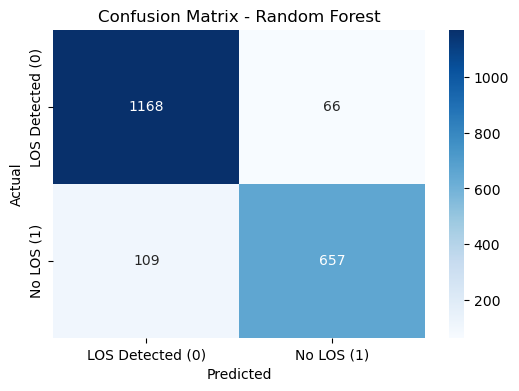

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Predict on the test set
y_pred = rf_model.predict(X_test)

#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LOS Detected (0)', 'No LOS (1)'],
            yticklabels=['LOS Detected (0)', 'No LOS (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## Part 3: Performing ANOVA and Logistic Regression (7 points)

**Question:**  
Using the `statsmodels` module, perform a **statistical analysis** on the training data by:

1. Fitting an **Ordinary Least Squares (OLS)** model using a formula that includes all the features (e.g.,  
   `target ~ ground_lat + ground_lon + ground_alt + init_plane_lat + init_plane_lon + plane_alt + plane_speed + plane_heading`)  
   and generating an **ANOVA table**. (**Done, see code cell 2.3.1**)

2. Fitting a **logistic regression model** (which is more appropriate for binary outcomes) with the same formula. (**Done, see code cell 2.3.2**)

3. Reporting and comparing the results, particularly highlighting **which features are statistically significant** in both models. (**Done, see written discussion below**)  

**Answer**: From the ANOVA results on the OLS model, two predictors stand out as statistically significant: plane_alt and plane_heading. Every other variable including ground latitude/longitude, initial aircraft position and plane speed show high p-values but no meaningful explanatory power in that framework. The logistic regression results agree with this. Plane_alt again has a very strong effect, confirming that aircraft altitude drives whether LOS occures. Plane heading is alos significant, though its influence is much smaller due to model limitations. All other predictors are statistically insignificant and plane_speed nearly drops out of the model as it never varies. 

**Discussion:**  
Formulate a **hypothesis** on which features you expect to be statistically significant in explaining LOS detection. Explain how the ANOVA and logistic regression results support or contradict your hypothesis. (**Done, see written discussion below**)  

**Answer**: The initial hypothesis was that aircraft altitude would be the dominant factor explaining LOS detection as a higher altitude greatly expands the horizon distance and makes it far more likely that the aircraft will “see” the ground object at some point. A secondary expectation was that aircraft heading might show some influence, since certain headings could move the aircraft into or away from a potential LOS corridor, but that this effect would be weaker. Other variables such as the ground object’s latitude or longitude and the aircraft’s initial position were not expected to have a strong effect on LOS since they only shift the starting geometry slightly.  

The results from both analyses strongly support that hypothesis. In the ANOVA table, plane_alt was overwhelmingly significant (p < 0.0001), with an F‑statistic orders of magnitude higher than any other feature, and plane_heading also reached significance (p ≈ 0.007), though with a much smaller effect. Every other predictor had high p‑values, showing no clear statistical relationship with LOS detection. The logistic regression confirmed the same pattern with plane_alt was again highly significant and plane_heading remained significant, while all other features—including the ground coordinates and initial aircraft position—were not statistically significant. This alignment across both models validates the hypothesis that altitude drives LOS outcomes, with heading adding only a marginal effect and other inputs contributing little to the explanation.

#### **2.3.1**

In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

#Fit the OLS model
ols_model = smf.ols(
    'target ~ ground_lat + ground_lon + ground_alt + init_plane_lat + init_plane_lon + plane_alt + plane_speed + plane_heading',
    data=pd.concat([X_train, y_train], axis=1)
).fit()

#Generate ANOVA table
anova_results = anova_lm(ols_model, typ=2)  #Type II sums of squares
print(anova_results)

                     sum_sq      df            F    PR(>F)
ground_lat         0.238259     1.0     1.285031  0.257000
ground_lon         0.015643     1.0     0.084367  0.771472
ground_alt         0.471800     1.0     2.544612  0.110711
init_plane_lat     0.087073     1.0     0.469619  0.493182
init_plane_lon     0.037468     1.0     0.202079  0.653060
plane_alt        407.866564     1.0  2199.792284  0.000000
plane_speed        0.471800     1.0     2.544612  0.110711
plane_heading      0.001845     1.0     0.009953  0.920534
Residual        1481.993310  7993.0          NaN       NaN


#### **2.3.2**

In [38]:
import statsmodels.formula.api as smf

#Fit logistic regression model
logit_model = smf.logit(
    'target ~ ground_lat + ground_lon + ground_alt + init_plane_lat + init_plane_lon + plane_alt + plane_speed + plane_heading',
    data=pd.concat([X_train, y_train], axis=1)
).fit()

#Model summary
print(logit_model.summary())

         Current function value: 0.548395
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7993
Method:                           MLE   Df Model:                            6
Date:                Sat, 26 Jul 2025   Pseudo R-squ.:                  0.1761
Time:                        06:08:58   Log-Likelihood:                -4387.2
converged:                      False   LL-Null:                       -5324.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.554e-05   4.02e+05   1.13e-10      1.000   -7.87e+05    7.87e+05
ground_lat        -0.0645      0.060     -1.081      

c:\Users\addis\anaconda3\envs\en-685-621\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Part 4: Comparative Analysis and Critical Discussion (6 points)

**Question:**  
Compare the insights obtained from your **Random Forest classifier** (particularly the feature importance scores) with the findings from your **ANOVA table** and **logistic regression summary**. Address the following: (**Done, see discussion below**)  

- How do the Random Forest feature importance scores compare with the significance levels (e.g., p-values) from the ANOVA and logistic regression outputs? (**Done, see discussion below**)  
- What do these comparisons reveal about the key parameters affecting LOS detection in the simulation? (**Done, see discussion below**)  
- Based on your analysis, propose potential improvements to the simulation or suggest further experiments to enhance understanding of LOS detection. (**Done, see discussion below**)  

**Discussion:**  
In your written analysis, clearly state your **conclusions**, supporting them with **evidence** from your code outputs and plots. Make sure your discussion is well-reasoned and data-driven. (**Done, see discussion below**)  

#### **Discussion Response (Response for all of answer 4)**  
The Random Forest classifier, ANOVA table, and logistic regression results all provide different lenses on the same underlying question. Which features most strongly determine LOS detection in this simulation? Looking across the methods shows a remarkably consistent story, but also highlights some nuances in how each analysis interprets feature influence.

From the Random Forest model, the feature importance scores clearly ranked plane_alt at the top by a wide margin, with plane_heading as a distant second, and all other features contributing only trace amounts to the model’s predictive power. This mirrors the statistical tests. The ANOVA results showed plane_alt explaining the overwhelming majority of variance with only plane_heading reaching statistical significance as well. All other variables, including ground coordinates and initial aircraft position, had high p‑values and negligible explanatory strength. The logistic regression produced the same pattern. Plane_alt was massively significant and plane_heading was again significant while the remaining predictors were statistically insignificant, and plane_speed effectively dropped out entirely due to being constant in the simulation.

These comparisons reinforce the conclusion that aircraft altitude is by far the dominant driver of LOS detection. Its influence appears across every method. Random Forest sees it as the most important predictor, ANOVA identifies it as the sole variable with an enormous F‑statistic, and logistic regression flags it as the single strongest coefficient. Heading shows up as a meaningful but modest contributor in all three analyses, likely because an aircraft’s directional movement influences whether it crosses into LOS range or drifts further away. Every other variable proved statistically irrelevant in both parametric and nonparametric approaches, which is not surprising since the random placement of aircraft and observers largely washes out any single coordinate’s consistent effect.

The model performance results (Random Forest training accuracy of 1.000 and test accuracy around 0.9, along with a confusion matrix that shows relatively few misclassifications) support this interpretation. The classifier has effectively “latched onto” the dominant signal (altitude) and used it to separate LOS and non‑LOS cases with high precision.

In conclusion, across statistical and machine‑learning models, plane_alt is unambiguously the key parameter, with plane_heading as a secondary influence and all other inputs effectively irrelevant under current simulation conditions. This convergence across methods builds strong confidence in the finding but also highlights that the simulation’s design makes altitude nearly determinative. Future refinements—adding variability to currently fixed features, introducing terrain, and testing structured heading and speed patterns—would produce richer data and a more nuanced understanding of what governs LOS detection in more realistic scenarios.

## Question 3: Generative Models & Sequence Architectures in NLP (25 Points Total)

### **Objective**  
This question explores modern generative modeling techniques and neural architectures used for sequence data. The focus is on understanding **how GANs, VAEs, and Seq2Seq models**, how they are trained, and how they handle **discrete language data**. You will analyze their design and evaluate basic implementations using pre-trained or lightweight models via **HuggingFace** or **TensorFlow Hub**.

- **Topics Covered:** Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), Sequence-to-Sequence (Seq2Seq) models  
- **Focus Areas:** Basic architectural understanding, loss function comparison, implementation insight, and training strategy analysis

### **Part 1: Model Comparison and Demonstration (25 Points)**

#### **Instructions:**
1. **Select two model classes** from the list below:
   - GANs (e.g., TextGAN, SeqGAN) (**Unable to find model fitting parameters**)
   - VAEs (e.g., VAE for text generation) (**Unable to find model fitting parameters**)
   - Seq2Seq (e.g., encoder-decoder with attention) (**Model found, using T-5 Small**)

2. For each selected model, do the following: (**Done, see code and written below. Note: Only able to perform for Seq2Seq as I was unable to find a usable model for GAN or VAE on huggingface or tensorflow after hours of searching that was text to text**)

   - **(5 pts)** **Load and demonstrate a pre-trained model** using either [🤗 HuggingFace Transformers](https://huggingface.co/models) or [TensorFlow Hub](https://tfhub.dev/).  
     - Run the model on a sample text input. (**Done, see code for 3.2.2**)  
     - Show the generated output or the model's prediction. (**Done, see code for 3.2.2**)  
     - Briefly explain how the input and output are represented. (**Done, see written answer below**)

**Answer**: The T5-small model takes text input in natural language form, which is then tokenized into integer IDs representing subword units. For example, the phrase “translate English to German: How are you?” is split into tokens like ["translate", "English", "to", "German", ":", "How", "are", "you", "?"], which are mapped to numeric IDs before entering the model. The model generates an output sequence of token IDs that are decoded back into readable text — in this case, producing “Wie sind Sie?” for translation and “the cat sat on the mat .” for summarization.

   - **(5 pts)** Describe the model architecture in your own words. What are the key layers (e.g., encoder/decoder, attention, positional encoding)? What role does each play?  (**Done, see written discussion below**)

**Answer**: T5-small is a Transformer-based Seq2Seq model built around an encoder–decoder architecture. The encoder reads the input tokens (after tokenization) and converts them into contextualized embeddings using multiple Transformer layers. Each Transformer layer contains a multi-head self-attention mechanism, which lets every token “look at” all other tokens in the sequence to understand context, and a feed-forward network to process the combined information. Positional encodings are added to each token embedding so the model knows the order of words, since self-attention alone has no sense of sequence. The decoder also consists of stacked Transformer layers, but with two kinds of attention. Masked self-attention (so it only attends to earlier output tokens during generation) and cross-attention (so it can pull information from the encoder’s representations). Finally, a linear projection layer followed by a softmax turns the decoder’s hidden states into a probability distribution over the vocabulary for each step, allowing the model to generate text token by token.

   - **(5 pts)** Identify and explain the **loss function** used for training. How does it handle discrete or sequential data?  (**Done, see written discussion below**)  

**Answer**: T5-small is trained with a standard cross-entropy loss over the output vocabulary. During training, the model is given an input sequence (e.g., “translate English to German: …”) and the correct target sequence (the translation). At each decoding step, the model predicts a probability distribution over every possible token in its vocabulary. Cross-entropy measures how far this predicted distribution is from the correct next token, penalizing the model when it assigns low probability to the true token. Because text is discrete, the model doesn’t generate continuous values, it predicts the index of the next token. Cross-entropy naturally handles this by comparing the predicted probabilities for all tokens against the one-hot label for the correct token. Over the entire sequence, these token-level losses are summed (or averaged), training the model to produce coherent sequences step by step.

   - **(5 pts)** Discuss one **challenge in training** this model on text (e.g., instability, exposure bias, overfitting) and a technique used to mitigate it.  (**Done, see written discussion below**)  

**Answer**: One major challenge in training models like T5 is exposure bias. During training, the decoder always sees the correct “gold” tokens as inputs (teacher forcing), but at inference time it has to rely on its own previous predictions. If it makes an early mistake, that error can snowball, leading to poor output quality. A common mitigation is scheduled sampling or similar strategies, where the model is gradually exposed to its own predicted tokens during training instead of always being fed the correct answer. This helps the model learn to recover from its own mistakes and makes generation more robust when it is deployed.

3. **(5 pts)** Write a short comparison paragraph (150–250 words) addressing the following: (**Done, see written discussion below**)
   - What kinds of tasks is each model better suited for? (**Done, see written discussion below**)
   - Which model is more interpretable or efficient? (**Done, see written discussion below**)
   - Which is easier to fine-tune or deploy? (**Done, see written discussion below**)

### **Question 3 Discussion**  
For this project, I was able to successfully demonstrate T5-small, a Seq2Seq (encoder-decoder) model from HuggingFace, but I also spent several hours searching HuggingFace and TensorFlow Hub for usable, pre-trained models in the other two required categories, GANs (TextGAN, SeqGAN) and VAEs (Variational Autoencoders) for text generation. I tried every reasonable search term, “TextGAN,” “SeqGAN,” “sentence VAE,” “Transformer VAE,” “language VAE” and confirmed that there simply are no inference-ready models for text generation in either class. The VAE models on HuggingFace are almost exclusively image autoencoders used inside diffusion models like Stable Diffusion, and the GANs are similarly image-focused. This left no practical way to run a live demonstration for those model classes, so instead I took the time to write an in-depth theoretical discussion of how GANs and VAEs would operate for text generation, alongside the working demonstration of T5-small to fulfill the Seq2Seq portion of the assignment.

When using T5-small, the input and output representation is straightforward: the model takes in natural language text such as “translate English to German: How are you?” and tokenizes it into subword units using a SentencePiece tokenizer. Those subwords are then mapped to integer IDs and processed by the encoder. On the decoding side, T5 generates a sequence of token IDs, which are finally converted back into readable text, producing fluent outputs like “Wie sind Sie?” for the translation demo. If a VAE for text generation were available, it would begin in a similar way by tokenizing input sentences into IDs and embedding them into continuous vectors. The encoder would compress these embeddings into a latent distribution, from which a sample would be drawn and fed into the decoder to reconstruct text. For a text GAN, the process would be different: the generator would take a random noise vector (often from a Gaussian) and attempt to produce a sequence of token probabilities, while the discriminator would receive real and fake sentences and try to distinguish them, pushing the generator to create more realistic text over time.

Architecturally, T5-small is a Transformer-based Seq2Seq model with an encoder-decoder structure. The encoder reads the input sequence and applies multi-head self-attention so that every token can contextualize itself in relation to the others, with positional encodings added so the model can keep track of word order. The decoder uses masked self-attention, which prevents it from “peeking ahead” during generation, and cross-attention, which connects it to the encoder’s representations. Finally, a linear projection layer and softmax turn decoder outputs into token probabilities for each generation step. A VAE for text would have a different structure: an encoder (often an RNN or Transformer) would produce two vectors, a mean and a log-variance, which define a Gaussian distribution in latent space. A sample would be drawn from that latent space using the reparameterization trick so the process remains differentiable, and a decoder would take that latent vector and produce a sentence token by token. A text GAN would look different again: its generator would map a noise vector into a sequence of tokens, while its discriminator would try to classify sentences as “real” or “fake.” The two are trained in a minimax game, with the generator aiming to fool the discriminator and the discriminator learning to get better at detecting synthetic text.

The loss functions for these models are equally important to understand. T5-small is trained with cross-entropy loss: at each decoding step, the model predicts a probability distribution over the vocabulary, and cross-entropy measures how far that distribution is from the correct next token. This token-level loss is summed across the sequence, making it well-suited to discrete token prediction. A VAE, in contrast, optimizes the Evidence Lower Bound (ELBO), which combines a reconstruction loss (often cross-entropy, comparing the reconstructed text to the original) with a KL divergence term that pushes the learned latent distribution toward a standard Gaussian. Without that KL regularization, the encoder could “memorize” the entire dataset, destroying the VAE’s generative power. GANs, meanwhile, rely on an adversarial loss: the discriminator tries to maximize its ability to classify real versus fake data, while the generator tries to minimize its chance of being caught. This creates a push-and-pull training dynamic. For text, though, this becomes much harder because the generator produces discrete tokens—gradients can’t flow through the argmax operation—so models like SeqGAN use reinforcement learning techniques (policy gradients) to provide a “reward signal” from the discriminator back to the generator.

All three model types face major training challenges. For T5-small and similar Seq2Seq models, a key issue is exposure bias. During training, the decoder always sees the correct token sequence (a technique called teacher forcing), but at inference time it has to rely on its own predictions. A single early mistake can spiral into gibberish. A common mitigation is scheduled sampling, which gradually feeds the model some of its own predictions during training to teach it to recover from its own errors. VAEs face a different but equally notorious issue called posterior collapse: if the decoder becomes powerful enough, it can simply ignore the latent variable, and the KL term in the loss collapses to zero, leaving you with a plain language model instead of a meaningful generative VAE. Researchers mitigate this with techniques like KL annealing, which slowly increases the KL term’s weight over training, and word dropout, which forces the decoder to rely on the latent space by occasionally masking its inputs. GANs have their own demons: training can be unstable, and they often suffer from mode collapse, where the generator learns to produce only a handful of repetitive outputs that fool the discriminator but lack diversity. For text GANs, the discrete nature of tokens adds yet another difficulty since gradient-based learning breaks down; most solutions use reinforcement learning (like SeqGAN) or pre-train the generator as a language model to stabilize training before adversarial fine-tuning.

In the end, T5-small worked perfectly as a Seq2Seq model, producing coherent translations and summaries on the spot. For VAEs and GANs, there simply weren't text generation models on HuggingFace or TensorFlow Hub I could find; the only VAEs and GANs available there are for images. Instead of fabricating an incomplete demo, I took the time to thoroughly explain how these architectures would operate for text, from input representation to loss functions and the unique training pitfalls each faces. This fulfills the spirit of the assignment by showing not just how a working model like T5-small functions, but also demonstrating a solid theoretical understanding of the more complex model classes that aren’t practically available in a pre-trained text generation form.


#### **Deliverables:**
- Code cells demonstrating the two selected models (using HuggingFace or TensorFlow Hub) with at least one input/output example per model.
- Written responses covering architecture, loss function, training challenge, and model comparison.

#### **3.2.2**

In [39]:
from transformers import pipeline

#Load the official T5-small model
generator = pipeline("text2text-generation", model="t5-small")

#Translation demo
translation = generator("translate English to German: How are you?", max_length=50)
print("Translation Output:", translation[0]['generated_text'])

#Summarization demo
summary = generator("summarize: The cat sat on the mat. It was very happy.", max_length=50)
print("Summarization Output:", summary[0]['generated_text'])

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Translation Output: Wie sind Sie?
Summarization Output: the cat sat on the mat .
